In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

from tqdm import tqdm, trange, tqdm_notebook

from matplotlib.pylab import get_cmap
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import scipy as sp
import sys, os
import cPickle as pickle
from glob import glob

fs=20
fs_ticks = 16
#sys.path.append('/Users/mhuber/PointSource/skylab/')
#from SkyMap import SkyMap

from scipy.stats import norm

# define sfb colors
colors = ['#3850A1', '#F79645', '#993A91']
#new trial
colors = ['#0D589A', '#5DB5D0', '#A9DBB7','blue']

from matplotlib.ticker import (AutoMinorLocator, FixedLocator, FuncFormatter,
                               MultipleLocator, NullLocator, LogLocator)
import healpy as hp

from scipy.interpolate import UnivariateSpline
from matplotlib.lines import Line2D
from copy import deepcopy

from scipy.interpolate import splrep, splev
from copy import deepcopy 

In [3]:
from tools import *
from tools import _trans

In [4]:
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LogNorm
from PyAstronomy import pyasl

In [5]:
from astropy import units as u
from astropy.coordinates import SkyCoord

# Get the detection efficiency from internal icecube mc

<IPython.core.display.Javascript object>


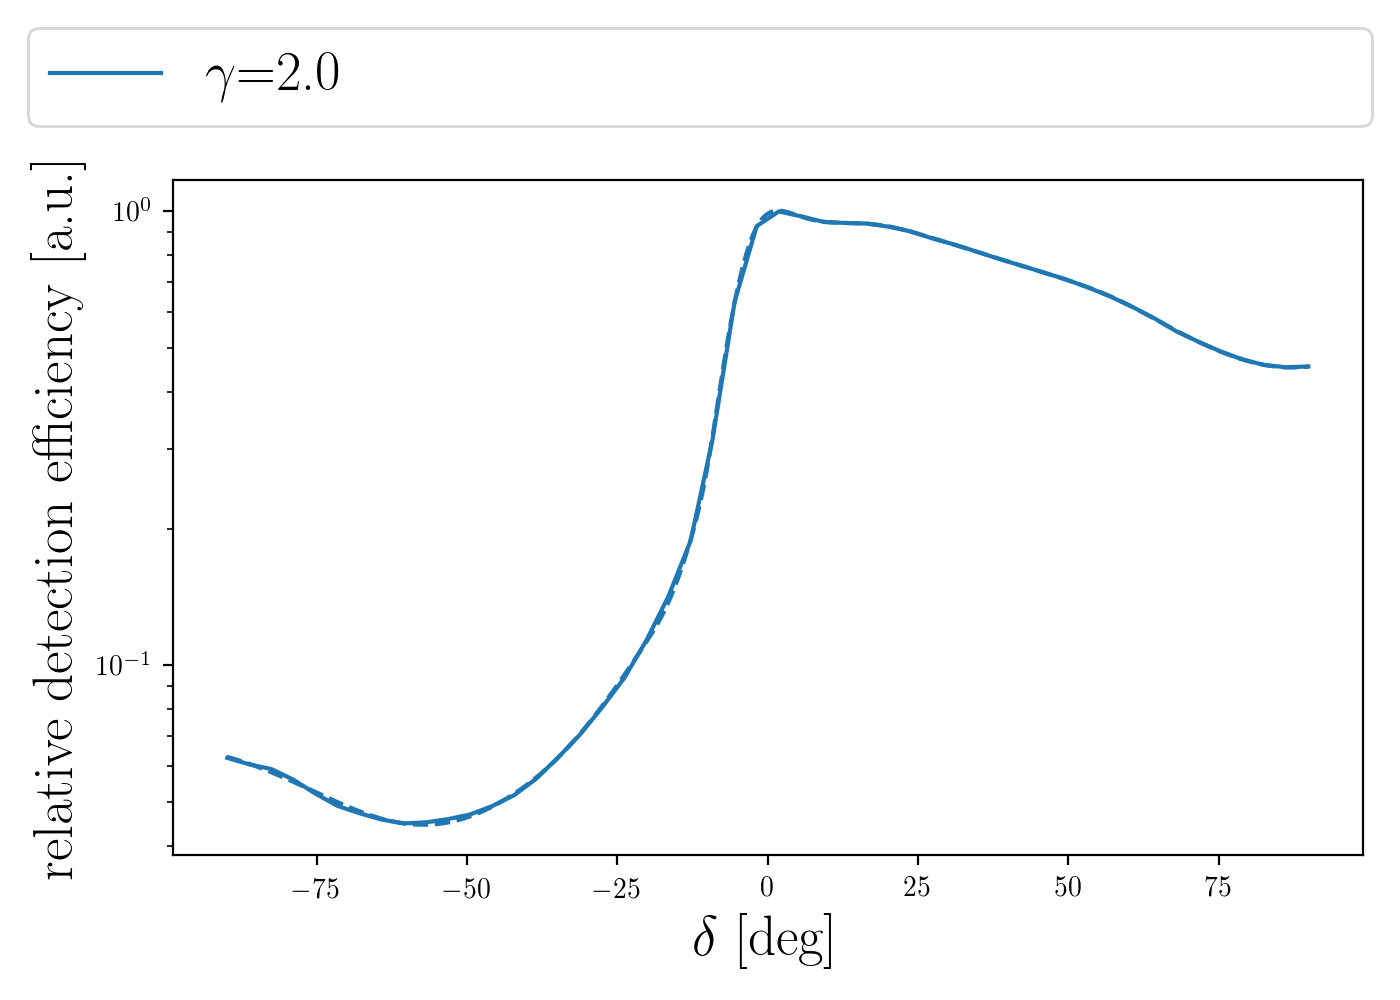

In [6]:
path = "/Users/mhuber/StackingSkylab/MultiYearPointSourceData/"
mc = np.load(os.path.join(path,'IC86-2012_MC.npy'))

ang=4
decs = np.linspace(-np.pi/2+np.radians(0.1), np.pi/2-np.radians(0.1), 50)
xvals = np.linspace(-np.pi/2, np.pi/2, 1000)

fig,ax=plt.subplots(figsize=(7,5))
tcks = dict()
gammas = [2.]
for gamma in gammas:
    
    Res = np.zeros_like(decs)
    for i, deci in enumerate(decs):
    
        if deci > np.radians(30): ang=10
        dec_min, dec_max = np.sin(deci-np.radians(ang)), np.sin(deci+np.radians(ang))
        Omega = 2 * np.pi * (dec_max - dec_min)
        dec_mask = (np.sin(mc['trueDec']) > dec_min)&(np.sin(mc['trueDec']) < dec_max)

        DetEff = np.sum(mc['ow'][dec_mask] * mc['trueE'][dec_mask]**(-gamma)) / Omega 
        Res[i] = DetEff
    
    Res_max = np.max(Res)
    Res /= np.max(Res)
    
    
    tck = splrep(decs, Res, s=1.e-4)
    spl_val = splev(xvals, tck)
    
    tcks[gamma] = tck
    p=ax.plot(np.degrees(decs), Res, label=r'$\gamma$={0:.1f}'.format(gamma))
    ax.plot(np.degrees(xvals), spl_val, ls='dashed', color=p[0].get_color())
    
fig.legend(loc='upper center', mode='expand', fontsize=fs, ncol=3)
ax.set_xlabel(r'$\delta$ [deg]',fontsize=fs)
ax.set_ylabel(r'relative detection efficiency [a.u.]',fontsize=fs)
ax.set_yscale('log')
fig.tight_layout()

plt.subplots_adjust(top = 0.82)

# Now get the detection efficiency from the public mc table

In [7]:
# show the public detection efficiency 
d_public = np.genfromtxt('/Users/mhuber/Downloads/3year-data-release/IC86-2012-TabulatedAeff.txt',
                        skip_header=1)

emin, emax = d_public[:,0], d_public[:,1]
dec_min, dec_mac = -np.arcsin(d_public[:,2]), -np.arcsin(d_public[:,3])
aeff = d_public[:,4]

print(max(aeff))
emids = (np.unique(emin)+np.unique(emax))/2.
ewidth = np.unique(emax)-np.unique(emin)

g_pub = 2
res_pub = np.zeros(len(np.unique(dec_min))-1) 
for i, deci in enumerate(np.unique(dec_min)[:-1]):
    mask = dec_min == deci
    
    res_pub[i] = np.sum(aeff[mask] * ewidth *emids**(-g_pub) )
    

18530.0


# Compare both outcomes 

<IPython.core.display.Javascript object>


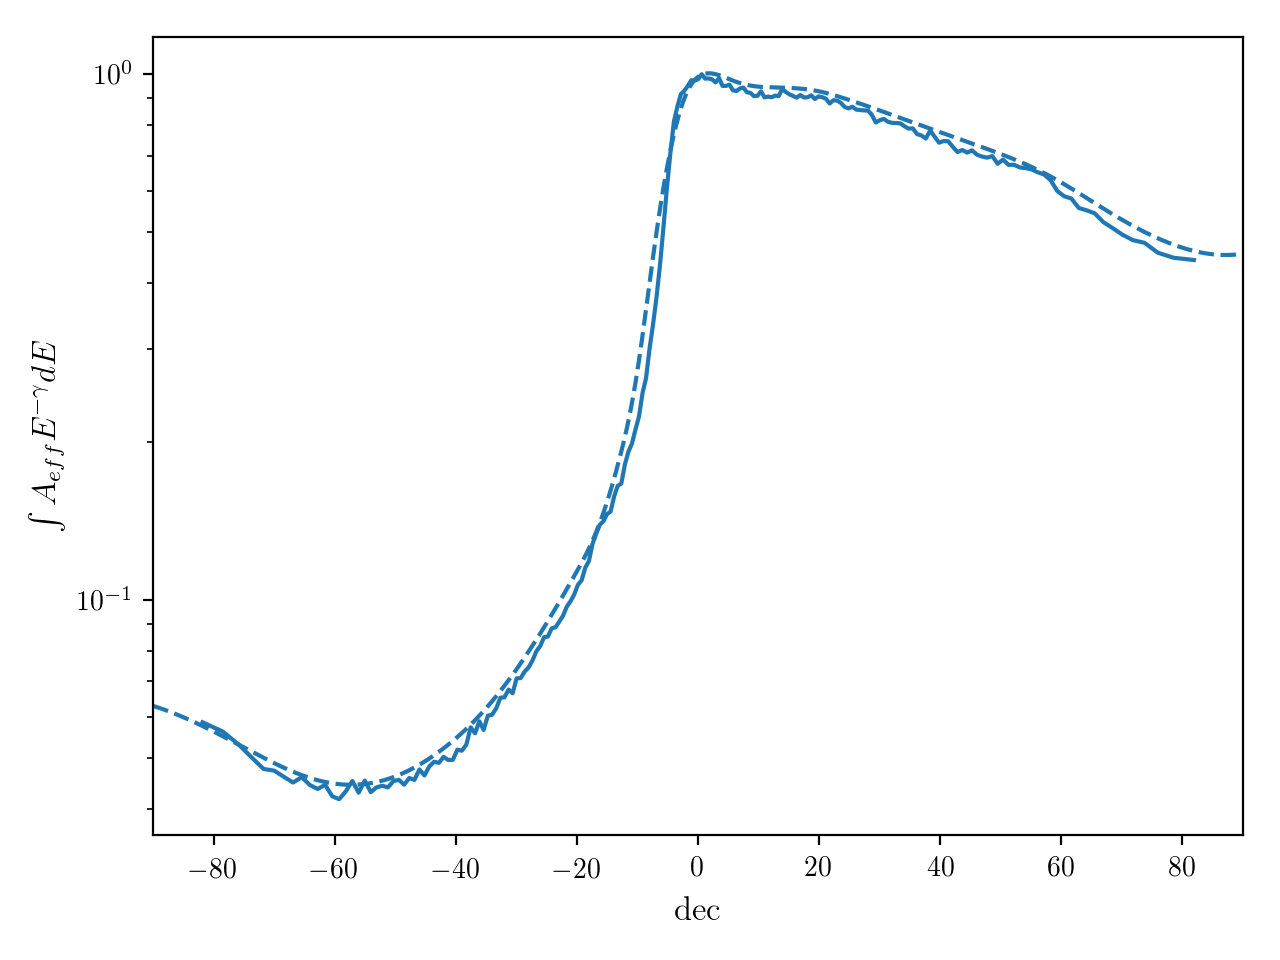

In [14]:
fig, ax = plt.subplots()

p=ax.plot(np.degrees(np.unique(dec_min)[:-1]), res_pub / res_pub.max())
ax.plot(np.degrees(xvals), spl_val, ls='dashed', color=p[0].get_color())

ax.set_xlabel(r'dec',fontsize=12)
ax.set_ylabel(r'$\int A_{eff} E^{-\gamma} dE$ ',fontsize=12)

ax.set_xlim(-90,90)
ax.set_yscale('log')

fig.tight_layout()
plt.show()